In [18]:
import numpy as np
from typing import List
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [73]:
def compute_f0(fs: List[int]):
    if fs[1] == 0:
        return (fs[0] * (fs[0] - 1)) / (2 * (fs[1]+1))
    return (fs[0]**2) / (2*fs[1])

In [98]:
def compute_variance(fs: List[int], Nhat: float):
    if fs[1] == 0:
        return (
            ((fs[0] * (fs[0] - 1)) / 2) + \
            ((fs[0]*((2*fs[0]-1)**2))/4) - \
            ((fs[0] ** 4)/Nhat)
        )
    # print('B')
    return (
        fs[1] * (
            (1/4)*((fs[0]/fs[1])**4) + \
            (fs[0]/fs[1])**3 + \
            ((1/2) * ((fs[0] / fs[1])**2))
        )
    )

In [100]:
def compute_confidence_inverval(n:int, f0_hat:float, variance:float, alpha:float):
    """
    Computes the 100(1-alpha)% confidence interval for N 
    """
    z_alpha = norm.ppf(1-(alpha/2))
    Q = np.exp(z_alpha * np.sqrt(np.log(1+((variance**2)/(f0_hat**2)))))
    return (
        n + (f0_hat / Q),
        n + (f0_hat * Q)
    )

In [101]:
def compute_fs(num_caught: np.ndarray, T: int):
    fs = np.zeros(T-1)
    for t in range(1, T):
        fs[t-1] = np.sum(num_caught == t)
    return fs.tolist()

In [109]:
N = 1000
T = 40
alpha = 0.01

num_caught = np.zeros(N)

history_N_hat = []
history_variance = []
history_f0_hat = []
history_true_f0 = []
history_confidence_interval = []

for t in tqdm(range(T), desc="Simulating..."):
    # uniform U(0.0, 0.01)
    probability_caught = np.random.uniform(0, 0.01, N)
    # # uniform U(0.0, 0.02)
    # probability_caught = np.random.uniform(0, 0.02, N)
    # # beta distribution B(1, 3)
    # probability_caught = 0.02 * np.random.beta(1, 3, N)
    # # beta distribution B(2, 2)
    # probability_caught = 0.02 * np.random.beta(2, 2, N)


    is_caught = np.random.uniform(0, 1, N) < probability_caught
    num_caught += is_caught

    fs = compute_fs(num_caught, T)
    n = sum(fs)
    f0_hat = compute_f0(fs)
    N_hat = n + f0_hat
    variance = compute_variance(fs, N_hat)
    confidence_interval = compute_confidence_inverval(n, f0_hat, variance, alpha)

    history_N_hat.append(N_hat)
    history_variance.append(variance)
    history_f0_hat.append(f0_hat)
    history_true_f0.append((num_caught == 0).sum())
    history_confidence_interval.append(confidence_interval)

Simulating...: 100%|██████████| 40/40 [00:00<00:00, 5828.26it/s]


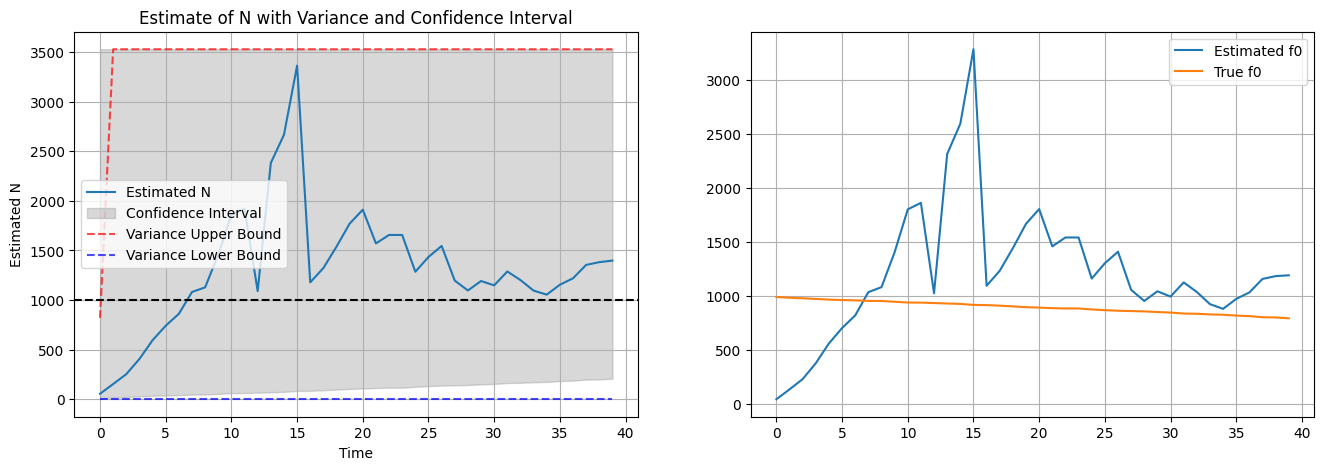

In [110]:
fig, ax = plt.subplots(1, 2,figsize=(16, 5))

# ax[0].plot(history_N_hat)
ax[0].set_title("Estimate of N with Variance and Confidence Interval")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Estimated N")
ax[0].plot(history_N_hat, label="Estimated N")

# Plot the variance upper bound but clip values above the original y-axis limits so the scale is unaffected
ymin, ymax = ax[0].get_ylim()

# Plot the confidence interval but clip values outside the original y-axis limits so the scale is unaffected
ci_lower = [max(ci[0], ymin) for ci in history_confidence_interval]
ci_upper = [min(ci[1], ymax) for ci in history_confidence_interval]
ax[0].fill_between(
    range(len(history_N_hat)),
    ci_lower,
    ci_upper,
    color="grey", alpha=0.3, label="Confidence Interval"
)

upper_var = [n + v for n, v in zip(history_N_hat, history_variance)]
# Keep unchanged values within limits, but clip values above ymax to ymax (so they are drawn but do not affect scale)
upper_var_clipped = [val if val <= ymax else ymax for val in upper_var]
ax[0].plot(
    upper_var_clipped,
    'r--', alpha=0.7, label="Variance Upper Bound"
)
ax[0].plot(
    [n - v if n - v > 0 else 0 for n, v in zip(history_N_hat, history_variance)],
    'b--', alpha=0.7, label="Variance Lower Bound"
)
ax[0].legend()
ax[0].axhline(y=N, color='r', linestyle='--', c='black', label="True N")

ax[1].plot(history_f0_hat, label="Estimated f0")
ax[1].plot(history_true_f0, label="True f0")
ax[1].legend()

ax[0].grid(True)
ax[1].grid(True)

plt.show()

In [48]:
(num_caught == 0).sum()

np.int64(819)